In [1]:
import os
import sys
work_dir = os.path.dirname(os.path.dirname(os.path.abspath('.')))
os.chdir(work_dir)
sys.path.append(os.path.join(work_dir,'src'))
sys.path.append(work_dir)
import numpy as np
import matplotlib.pyplot as plt
from src.approaches import Net
import torch_geometric.transforms as T
import torch
import yaml
from src.brain_data import HemiBrain
from os.path import join
import random
import networkx as nx
import navis
PROXY=False
if PROXY:
    import socket
    import socks
    #SOCKS5_PROXY_HOST = '10.254.24.15'
    SOCKS5_PROXY_HOST = '127.0.0.1'
    SOCKS5_PROXY_PORT = 7890 
    default_socket = socket.socket
    socks.set_default_proxy(socks.SOCKS5, SOCKS5_PROXY_HOST, SOCKS5_PROXY_PORT)
    socket.socket = socks.socksocket
import navis.interfaces.neuprint as neu
from neuprint import NeuronCriteria as NC
from neuprint.queries import fetch_all_rois,fetch_neurons,fetch_primary_rois, fetch_adjacencies
token='' 
client = neu.Client('https://neuprint.janelia.org/', dataset='hemibrain:v1.2.1',token=token)
save_dir=join(work_dir,'example')
work_dir

'/data/users/wgj/project/NCPNet'

In [2]:
config=join(work_dir, 'Plot_figure/Main_content/save_demo_fly/config.yaml')
model_para=join(work_dir,'Plot_figure/Main_content/save_demo_fly/checkpoint_best_model.pt')
#config=join(work_dir, 'runs/demo_model/Jun12_10-38-05_amax/config.yaml')
#model_para=join(work_dir,'runs/demo_model/Jun12_10-38-05_amax/checkpoint_best_model.pt')

In [3]:
with open(config,'r') as fin:
    task=yaml.load(fin)


task['type_dim']=5555
task['device']='cpu'
model=Net(task)
checkpoint=torch.load(model_para,map_location='cpu')
model.load_state_dict(checkpoint.state_dict())
model.cpu()


/data/users/wgj/miniconda3/envs/pygeo/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


Net(
  (Deco): LinkPred(
    (predictor): mlptri_predictor(
      (mlp): Sequential(
        (0): Linear(in_features=192, out_features=256, bias=True)
        (1): Dropout(p=0.5, inplace=True)
        (2): ReLU(inplace=True)
        (3): Linear(in_features=256, out_features=128, bias=True)
        (4): Dropout(p=0.5, inplace=True)
        (5): ReLU(inplace=True)
        (6): Linear(in_features=128, out_features=1, bias=False)
      )
    )
    (nei_encoder): NeighEnco2(
      (lookupneigh): Lookup_neighbor_embedding()
      (conv1): Conv1d(64, 32, kernel_size=(1,), stride=(1,), bias=False)
      (act_f1): LeakyReLU(negative_slope=0.05)
      (dp1): Dropout(p=0.5, inplace=True)
      (conv2): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      (act_f2): LeakyReLU(negative_slope=0.05)
      (dp2): Dropout(p=0.5, inplace=True)
    )
  )
  (node_Enco): GCN(
    (node_attr_layer): node_attr_encoder(
      (drop1): Dropout(p=0.5, inplace=True)
    )
    (conv1): GCNConv(100, 128)

In [4]:
path = join('data', task['Experiment'])
train_split=join(work_dir,'runs/NCPNet_demo_model/checkpoint_save/train_data.dt')
test_split=join(work_dir,'runs/NCPNet_demo_model/checkpoint_save/test_data.dt')
train_data=HemiBrain(path,transform=None,restore_split=train_split,device='cpu')

test_data=HemiBrain(path,transform=None,restore_split=test_split,device='cpu')
x=train_data.data.x.cpu()
edge_index=train_data.data.edge_index.cpu()
z=model.node_Enco(x=x,edge_index=edge_index)


In [5]:
from NCPNet.utils import edge_index2Graph
from NCPNet.brain_data import LinkPred_PairNeigh_Loader
num_neuron=z.shape[0]
nxg=edge_index2Graph(edge_index)
nxg.to_undirected()
loader=LinkPred_PairNeigh_Loader(task,train_data,nxg)


In [6]:
id2type={}


neutype_con={}
with open(join(work_dir,'data/HemiBrain/raw/neuron-label.txt'),'r') as fin:
    for i in fin.readlines():
        line=i.strip().split()
        if len(line)==2:
            id2type[int(line[0])]=line[1]
            if line[1] in neutype_con:
                neutype_con[line[1]].append(int(line[0]))
            else:
                neutype_con[line[1]]=[int(line[0])]
neu2ID=train_data.neu2ID
id2neu={v:k for k,v in neu2ID.items() }
id2type=train_data.neuron2label


In [7]:

#query_neuron='454693209'
query_neuron='509410587'
#query_neuron='126526132'
#query_neuron='730013818'
#query_neuron='849421763'
#query_neuron='757055317'
#query_neuron='849482511'
#query_neuron='488184014'
pre_synap=[]
pre_synap_type=[]
for i in range(train_data.num_nodes):
    pre_synap.append([neu2ID[query_neuron],i])
    j=id2neu[i]
    pre_synap_type.append([neu2ID[query_neuron],id2type[j]])
pre_synap=torch.tensor(pre_synap)
pre_synap=pre_synap.T

post_synap=[]
post_synap_type=[]
for i in range(train_data.num_nodes):
    post_synap.append([i,neu2ID[query_neuron]])
    j=id2neu[i]
    post_synap_type.append([id2type[j],neu2ID[query_neuron]])
post_synap=torch.tensor(post_synap)
post_synap=post_synap.T


In [10]:
from plot_utils import vfb2,vol2
vfb2.color=vol2.color
case=neu.fetch_skeleton(int(query_neuron))
case=navis.NeuronList([case])


In [ ]:
# fig,ax=plt.subplots(1,1,figsize=(8,8),subplot_kw=dict(projection="3d"))
# navis.plot2d(vfb2,ax=ax,method='3d',c='r',linewidth=0.2)
plt.cla()
plt.clf()
fig, ax=navis.plot2d([vfb2,case],method='3d',c='r',figsize=(12,12))
#navis.plot2d(case,ax=ax,method='3d_complex',c='r',lienwidth=0.2)
ax.azim = -90
ax.dist = 7
ax.elev=20
fig.savefig(join(save_dir,'Query_neuron%s.png'%query_neuron),dpi=300)


In [9]:
model.eval()
if model.use_pair_enco:
    neighbors=loader.get_neighboor(pre_synap,max_num=4)
    neighbors=neighbors.contiguous()
    out=model.Deco(z,pre_synap,neighbor=neighbors)
else:
    out=model.Deco(z,pre_synap)

hist_x=out.detach().cpu().numpy()


In [10]:
model.eval()
if model.use_pair_enco:
    neighbors=loader.get_neighboor(post_synap,max_num=4)
    neighbors=neighbors.contiguous()
    out=model.Deco(z,post_synap,neighbor=neighbors)
else:
    out=model.Deco(z,post_synap)

hist_x2=out.detach().cpu().numpy()


/data/users/wgj/miniconda3/envs/pygeo/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/data/users/wgj/miniconda3/envs/pygeo/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/data/users/wgj/miniconda3/envs/pygeo/lib/python3.7/site-packages/IPython/core/pylabtools.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


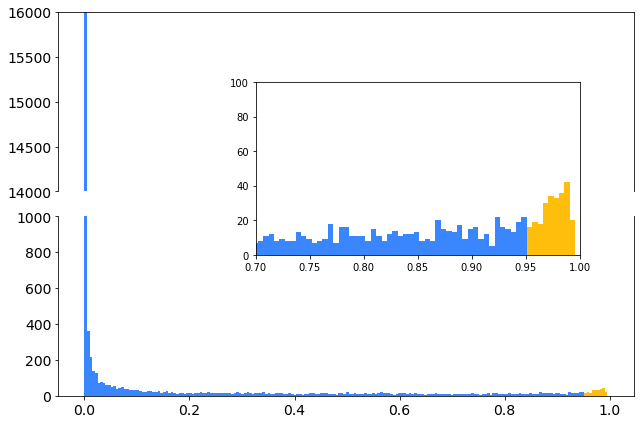

In [11]:
fig,[ax1,ax2]=plt.subplots(2,1,figsize=(9,6),layout='tight')

color='#3A86FF'
hit_color='#FFBE0B'
for l in [ax1,ax2]:
    l.tick_params(labelsize=14)
#bax=brokenaxes(xlims=None,ylims=((0,1000),(14000,16000)),hspace=0.05,fig=fig)
ax1.hist(hist_x,bins=200,color=color)
ax1.set_ylim(14000,16000)
n, bins, patches=ax2.hist(hist_x,bins=200,color=color)
ax2.set_ylim(0,1000)
ax1.spines.bottom.set_visible(False)
ax1.set_xticks([])
ax2.spines.top.set_visible(False)
for p in patches:
    x=p.xy[0]
    if x>=0.95:p.set_facecolor(hit_color)

ax2sub=fig.add_axes([0.4,0.4,0.5,0.4])

_,__,patches=ax2sub.hist(hist_x,bins=200,color=color)
ax2sub.set_ylim(0,100)
ax2sub.set_xlim(0.7,1.0)
for p in patches:
    x=p.xy[0]
    if x>=0.95:p.set_facecolor(hit_color)


fig.savefig(join(save_dir,'%s-(n->?).eps'%(query_neuron)))


In [12]:
#topk=[1,3,5,10,20,50,100,200,400]
topk=[1,3,5,10,20,50]
hist_x_list=hist_x.squeeze().tolist()

top_x=sorted(zip(range(len(hist_x_list)),hist_x_list),key=lambda x:x[1],reverse=True)

topk_group={}
last=None
for k,i in enumerate(topk):
    if last==None:
        l=top_x[0][0]

        topk_group[i]=[id2neu[l]]
        last=i
    else:

        l=[id2neu[j[0]] for j in top_x[last:i]]
        topk_group[i]=l
        last=i
topk_group_fetch={}
fetch_cache={}
for k,v in topk_group.items():
    v=[int(c) for c in v]
    case=[]
    for id in v:
        
        try:
            sklt=neu.fetch_skeleton(id)
            case.append(sklt)
            fetch_cache[id]=sklt
        except:
            print('missing neuron %d'%id)
    topk_group_fetch[k]=navis.NeuronList(case)
    print('Successsfully fetch neurons:%s'%str(v))


Successsfully fetch neurons:[696362840]


Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Successsfully fetch neurons:[1002852791, 789126240]


Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Successsfully fetch neurons:[1192152791, 572870540]


Make nrn:   0%|          | 0/5 [00:00<?, ?it/s]

Successsfully fetch neurons:[941132434, 665314820, 5813027103, 694920753, 5813056953]


Make nrn:   0%|          | 0/10 [00:00<?, ?it/s]

Successsfully fetch neurons:[1447576662, 5813022281, 1197993940, 1318109929, 1352823209, 541870397, 1449247522, 1508369047, 1228692168, 633546217]


Make nrn:   0%|          | 0/30 [00:00<?, ?it/s]

Successsfully fetch neurons:[1292847181, 478375456, 5813077544, 5813040233, 1229369776, 570461892, 5813080838, 509410587, 819828986, 725951521, 1167645442, 1321140852, 663190769, 697001770, 912601268, 910438331, 1168660239, 1292882359, 449438847, 1136865339, 758419409, 1168659995, 1137288015, 1167891559, 941469087, 911211196, 1002848124, 912545106, 725951660, 942587380]


Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/5 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/10 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/30 [00:00<?, ?it/s]

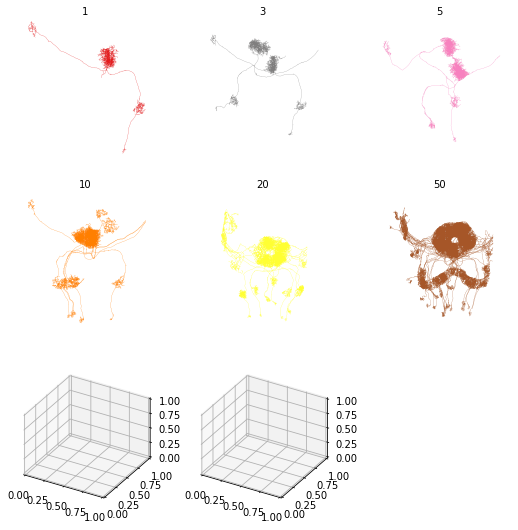

In [13]:

topk_score_group={}
last=None
for k,i in enumerate(topk):
    if last==None:
        l=top_x[0][1]

        topk_score_group[i]=[l]
        last=i
    else:

        l=[j[1] for j in top_x[last:i]]
        topk_score_group[i]=l
        last=i

colors=['#E41A1C','#7F7E7E','#F781BF','#FF7F00','#FFFF33','#A65628','#984EA3','#277DA1','#277DA1']
bodyid=int(query_neuron)

num_fig=len(topk_group_fetch)
col=iter(colors)
dex=0
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(9,9),subplot_kw=dict(projection="3d"))
#fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(9,9))
for k,v in topk_group_fetch.items():
    cax=ax[dex//3][dex%3]
    navis.plot2d(v,ax=cax,soma=False,method='3d',c=colors[dex],linewidth=0.2)
    cax.azim = -90
    cax.dist = 7
    cax.elev=20
    cax.set_title(str(k),fontsize=10)
    cax.axis('off')
    dex+=1
# fig.savefig(join(save_dir,'pre-synap-tophit-%s.pdf'%(query_neuron)),facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format=None,\
#             transparent=False, 
#             bbox_inches=None, 
#             pad_inches=0.1,
#             frameon=None, 
#             metadata=None)
fig.savefig(join(save_dir,'pre-synap-tophit-%s.png'%(query_neuron)))


/data/users/wgj/miniconda3/envs/pygeo/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/data/users/wgj/miniconda3/envs/pygeo/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/data/users/wgj/miniconda3/envs/pygeo/lib/python3.7/site-packages/IPython/core/pylabtools.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


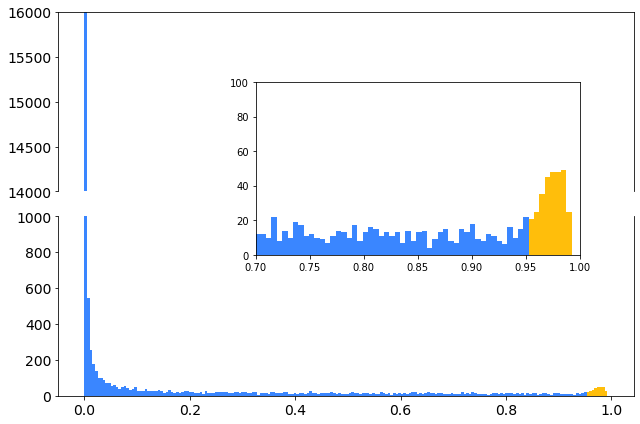

In [14]:
fig,[ax1,ax2]=plt.subplots(2,1,figsize=(9,6),layout='tight')

color='#3A86FF'
hit_color='#FFBE0B'
for l in [ax1,ax2]:
    l.tick_params(labelsize=14)
#bax=brokenaxes(xlims=None,ylims=((0,1000),(14000,16000)),hspace=0.05,fig=fig)
ax1.hist(hist_x2,bins=200,color=color)
ax1.set_ylim(14000,16000)
n, bins, patches=ax2.hist(hist_x2,bins=200,color=color)
ax2.set_ylim(0,1000)
ax1.spines.bottom.set_visible(False)
ax1.set_xticks([])
ax2.spines.top.set_visible(False)
for p in patches:
    x=p.xy[0]
    if x>=0.95:p.set_facecolor(hit_color)

ax2sub=fig.add_axes([0.4,0.4,0.5,0.4])
_,__,patches=ax2sub.hist(hist_x2,bins=200,color=color)
ax2sub.set_ylim(0,100)
ax2sub.set_xlim(0.7,1.0)
for p in patches:
    x=p.xy[0]
    if x>=0.95:p.set_facecolor(hit_color)
fig.savefig(join(save_dir,'%s-(?->n).eps'%(query_neuron)))


In [15]:

hist_x_list=hist_x2.squeeze().tolist()

top_x=sorted(zip(range(len(hist_x_list)),hist_x_list),key=lambda x:x[1],reverse=True)

topk_group={}
last=None
for k,i in enumerate(topk):
    if last==None:
        l=top_x[0][0]

        topk_group[i]=[id2neu[l]]
        last=i
    else:

        l=[id2neu[j[0]] for j in top_x[last:i]]
        topk_group[i]=l
        last=i
topk_group_fetch={}
for k,v in topk_group.items():
    v=[int(c) for c in v]
    case=[]
    for id in v:
        if id in fetch_cache:
            case.append(fetch_cache[id])
        else:
            
            try:
                sklt=neu.fetch_skeleton(body=id)
                case.append(sklt)
            except:
                print('missing neuron %d'%id)
    topk_group_fetch[k]=navis.NeuronList(case)
    print('Successsfully fetch neurons:%s'%str(v))


Successsfully fetch neurons:[1509439784]


Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Successsfully fetch neurons:[696362840, 1192152791]


Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Successsfully fetch neurons:[5813022281, 1125964630]


Make nrn:   0%|          | 0/5 [00:00<?, ?it/s]

Successsfully fetch neurons:[1002852791, 1229369776, 1353544607, 1167645442, 1168659995]


Make nrn:   0%|          | 0/10 [00:00<?, ?it/s]

Successsfully fetch neurons:[1352823209, 941132434, 5813053988, 572870540, 910438331, 694920753, 1292847181, 5813062858, 665314820, 1002507131]


Make nrn:   0%|          | 0/30 [00:00<?, ?it/s]

Successsfully fetch neurons:[509410587, 1318109929, 5813056953, 1447576662, 1002848124, 570461892, 727350004, 911241750, 1167891559, 885948438, 1631450739, 880875861, 1136865339, 634608104, 919763043, 1197993940, 1137288015, 5813027103, 918334668, 1228692168, 1198330286, 1036753721, 5813060726, 508793049, 789126240, 1127471692, 5813055913, 664650297, 1535298460, 541870397]


Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/5 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/10 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/30 [00:00<?, ?it/s]

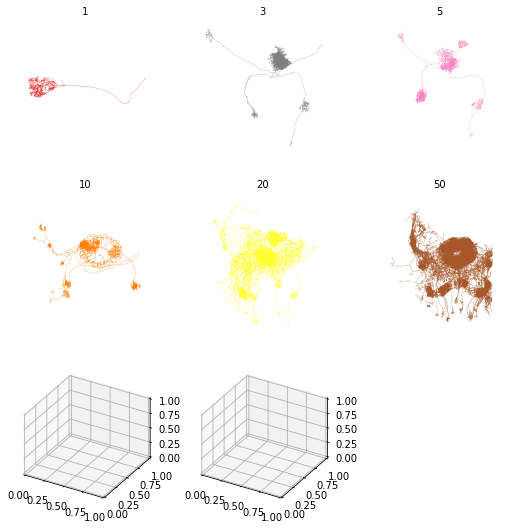

In [16]:

topk_score_group={}
last=None
for k,i in enumerate(topk):
    if last==None:
        l=top_x[0][1]

        topk_score_group[i]=[l]
        last=i
    else:

        l=[j[1] for j in top_x[last:i]]
        topk_score_group[i]=l
        last=i

colors=['#E41A1C','#7F7E7E','#F781BF','#FF7F00','#FFFF33','#A65628','#984EA3','#277DA1','#277DA1']
bodyid=int(query_neuron)

num_fig=len(topk_group_fetch)
col=iter(colors)
dex=0
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(9,9),subplot_kw=dict(projection="3d"))
#fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(9,9))
for k,v in topk_group_fetch.items():
    cax=ax[dex//3][dex%3]
    navis.plot2d(v,ax=cax,soma=False,method='3d',c=colors[dex],linewidth=0.2)
    cax.azim = -90
    cax.dist = 7
    cax.elev=20
    cax.set_title(str(k),fontsize=10)
    cax.axis('off')
    dex+=1
# fig.savefig(join(save_dir,'post-synap-tophit-%s.pdf'%(query_neuron)),facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format=None,\
#             transparent=False, 
#             bbox_inches=None, 
#             pad_inches=0.1,
#             frameon=None, 
#             metadata=None)
fig.savefig(join(save_dir,'post-synap-tophit-%s.png'%(query_neuron)))
